In [26]:
from openpyxl import Workbook, load_workbook
from docx import Document
from string import punctuation
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt 

import os
import shutil
import re

import warnings
warnings.filterwarnings('ignore')

In [2]:
color_2_num = {
    'YELLOW' : 7,
    'BRIGHT_GREEN' : 4,
    'DARK_YELLOW' : 14,
    'RED' : 6,
    'TURQUOISE' : 3,
    'GRAY' : 16
}

color_2_label = {
    'YELLOW' : "Thesis",
    'BRIGHT_GREEN' : "Organizational Framework",
    'DARK_YELLOW' : "Rhetorical Structure - Focus",
    'RED' : "Evidence",
    'TURQUOISE' : "Reasoning",
    'GRAY' : "Rhetorical Structure - Progression"
}

In [3]:
root_folder = 'input_files_v3/Annotated_Papers'
folder_names = os.listdir(root_folder + '/')

root_save_folder = 'output_files'

In [4]:
name_mapping = {"AC" : "Andrew Chapman",
                "AN" : "Ashlan Stewart",
                "BA" : "Beatriz Acosta-Tsvilin",
                "JM" : "Jasmine McCray",
                "JD" : "Jessica Dobbs",
                "MK" : "Maliha Kabir",
                "MB" : "Marina Banchetti",
                "NC" : "Nikki Chasteen",
                "SN" : "Sarah Nielsen"}

id_mapping = {"AC" : 'C',
               "AN" : 'D',
               "BA" : 'E',
               "JM" : 'F',
               "JD" : 'G',
               "MK" : 'H',
               "MB" : 'I',
               "NC" : 'J',
               "SN" : 'K'}

In [5]:
folder_names

['Annotated AC 1',
 'Annotated AC 10',
 'Annotated AC 2',
 'Annotated AC 3',
 'Annotated AC 4',
 'Annotated AC 5',
 'Annotated AC 6',
 'Annotated AC 7',
 'Annotated AC 8',
 'Annotated AC 9',
 'Annotated AN 1',
 'Annotated AN 10',
 'Annotated AN 2',
 'Annotated AN 3',
 'Annotated AN 4',
 'Annotated AN 5',
 'Annotated AN 6',
 'Annotated AN 7',
 'Annotated AN 8',
 'Annotated AN 9',
 'Annotated BA 1',
 'Annotated BA 2',
 'Annotated BA 5',
 'Annotated BA 7',
 'Annotated JD 1',
 'Annotated JD 10',
 'Annotated JD 2',
 'Annotated JD 3',
 'Annotated JD 4',
 'Annotated JD 5',
 'Annotated JD 6',
 'Annotated JD 7',
 'Annotated JD 8',
 'Annotated JD 9',
 'Annotated JM 1',
 'Annotated JM 10',
 'Annotated JM 2',
 'Annotated JM 3',
 'Annotated JM 4',
 'Annotated JM 5',
 'Annotated JM 6',
 'Annotated JM 7',
 'Annotated JM 8',
 'Annotated JM 9',
 'Annotated MB 1',
 'Annotated MB 10',
 'Annotated MB 2',
 'Annotated MB 3',
 'Annotated MB 4',
 'Annotated MB 6',
 'Annotated MB 7',
 'Annotated MB 8',
 'Annot

In [6]:
# creating a set of all file IDs
id_locations = dict()
for folder in folder_names:
    grader_folders = os.listdir(root_folder + '/' + folder + '/')
    # for grader_folder in grader_folders:
    file_names = os.listdir(root_folder + '/' + folder + '/') # + grader_folder + '/'
    for file in file_names:
        name, ext = os.path.splitext(file)
        if ext != '.docx':
            print('/' + '/' + file)
            continue
        file_id = file.split('-')[0]
        if file_id in id_locations:
            id_locations[file_id].append(root_folder + '/' + folder + '/' + '/' + file)
        else:
            id_locations[file_id] = [root_folder + '/' + folder + '/' + '/' + file]

print(f'Total Files - {len(id_locations)}')

Total Files - 192


In [7]:
cust_punct = '!@#$%^&*()-=_+`~[]\{}|;:,./<>?' + '"' + "'" + '“”„‟‘’‚‛' + '\n' + ' ' # + ' '
alpha_num = '[^a-zA-Z0-9]'

In [8]:
id_locations['09949']

['input_files_v3/Annotated_Papers/Annotated AC 7//09949-FinalDraft-7n797.docx',
 'input_files_v3/Annotated_Papers/Annotated AN 7//09949-FinalDraft-7n797.docx',
 'input_files_v3/Annotated_Papers/Annotated MB 7//09949-FinalDraft-7n797.docx']

In [9]:
new_data = dict()
pairwise_consis = dict()
# no_highlight_files = [] # to find files with no highlighting at all.

for file_id in id_locations.keys():    # ['09516']:
    total_words = []
    all_words = []
    rater_names = []
    for file_location in id_locations[file_id]:
        rater = file_location.split('/')[2].split()[1]
        # print(file_location)
        doc = Document(file_location)
        total_string = []
        prev, curr = 'normal_text', 'normal_text'
        # is_highlighted = False   # for checking if the current file has annotations or not.
        for paragraph in doc.paragraphs:
            runs = paragraph.runs
            n_runs = len(runs)
            temp_string = ""
            for i in range(n_runs):
                if runs[i].font.highlight_color:
                    # is_highlighted = is_highlighted or True   # if there is any run with a highlight, make is_highlighted = True
                    if runs[i].font.highlight_color == color_2_num['YELLOW']:
                        curr = color_2_label['YELLOW']
                    elif runs[i].font.highlight_color == color_2_num['BRIGHT_GREEN']:
                        curr = color_2_label['BRIGHT_GREEN']
                    elif runs[i].font.highlight_color == color_2_num['DARK_YELLOW']:
                        curr = color_2_label['DARK_YELLOW']
                    elif runs[i].font.highlight_color == color_2_num['RED']:
                        curr = color_2_label['RED']
                    elif runs[i].font.highlight_color == color_2_num['TURQUOISE']:
                        curr = color_2_label['TURQUOISE']
                    elif runs[i].font.highlight_color == color_2_num['GRAY']:
                        curr = color_2_label['GRAY']
                else:
                    curr = 'normal_text'
                    
                if curr == prev:
                    temp_string += re.sub(alpha_num, ' ', runs[i].text)
                else:
                    total_string += [[i, prev] for i in temp_string.strip().split() if i.strip()]
                    temp_string = re.sub(alpha_num, ' ', runs[i].text)
                    
                if i == n_runs - 1:
                    total_string += [[i, curr] for i in temp_string.strip().split() if i.strip()]

                prev = curr
        total_words.append(len(total_string))
        all_words.append(total_string)
        rater_names.append(rater)
        
        # if not is_highlighted:  # add the file_location to the list if none of the runs has a highlight
        #     no_highlight_files.append(file_location)
    
    if all(i == total_words[0] for i in total_words) and len(total_words) > 1:
        # print(file_id, total_words)
        new_data[file_id] = all_words

        pairwise_consis[file_id] = dict(zip(rater_names, all_words))

In [10]:
name_index_map = {'AC':0, 'AN':1, 'BA':2, 'JD':3, 'JM':4, 'MB':5, 'MK':6, 'NC':7, 'SN':8}

rater_matrix = []

for _ in name_index_map.keys():
    rater_matrix.append([[] for i in name_index_map.keys()])

In [11]:
all_pairwise_scores = []
individual_rater_score = dict()
for file_id in pairwise_consis.keys():
    # print(f'{file_id} :')
    rater_names = list(pairwise_consis[file_id].keys())
    for i in range(0, len(rater_names)-1):
        df1 = pd.DataFrame(pairwise_consis[file_id][rater_names[i]], columns =['word', 'label'])
        rater_1 = rater_names[i]
        for j in range(i+1, len(rater_names)):
            df2 = pd.DataFrame(pairwise_consis[file_id][rater_names[j]], columns =['word', 'label'])
            rater_2 = rater_names[j]
            
            labels = list(set(df1.label.unique()).union(df2.label.unique()))
            if len(set(labels)) != 1:
                score = np.round(cohen_kappa_score(df1.label, df2.label, labels=labels), 2)
                all_pairwise_scores.append(score)

                rater_matrix[name_index_map[rater_1]][name_index_map[rater_2]].append(score)
                rater_matrix[name_index_map[rater_2]][name_index_map[rater_1]].append(score)
                
                if rater_1 in individual_rater_score:
                    individual_rater_score[rater_1].append(score)
                else:
                    individual_rater_score[rater_1] = [score]
                
                if rater_2 in individual_rater_score:
                    individual_rater_score[rater_2].append(score)
                else:
                    individual_rater_score[rater_2] = [score]

                # print(f' {rater_names[i]} {rater_names[j]}: {np.round(score, 2)}')

all_pairwise_scores = pd.DataFrame(all_pairwise_scores, columns=['scores'])

In [12]:
len(rater_matrix)

9

In [13]:
consistency_matrix = pd.DataFrame(np.ones((9, 9), dtype=int), index=[*name_index_map.keys()], columns=[*name_index_map.keys()])

for rater_1 in name_index_map.keys():
    for rater_2 in name_index_map.keys():
        scores = rater_matrix[name_index_map[rater_1]][name_index_map[rater_2]]
        if len(scores) != 0:
            score = np.round(np.average(scores), 2)
        else:
            if rater_1 == rater_2:
                score = 100
            else:
                score = 0 #'NA'
        consistency_matrix.loc[rater_1, rater_2] = score
        # consistency_matrix.loc[rater_2, rater_1] = score

In [14]:
# for file_id in pairwise_consis.keys():
#     print(pairwise_consis[file_id].keys())

In [15]:
consistency_matrix

,AC,AN,BA,JD,JM,MB,MK,NC,SN
AC,100.00,0.49,0.00,0.51,0.45,0.29,0.53,0.51,0.64
AN,0.49,100.00,0.22,0.38,0.57,0.32,0.43,0.30,0.92
BA,0.00,0.22,100.00,0.00,0.17,0.27,0.00,0.00,0.00
JD,0.51,0.38,0.00,100.00,0.45,0.61,0.48,0.37,0.46
JM,0.45,0.57,0.17,0.45,100.00,0.53,0.53,0.26,0.73
MB,0.29,0.32,0.27,0.61,0.53,100.00,0.50,0.32,0.00
MK,0.53,0.43,0.00,0.48,0.53,0.50,100.00,0.57,0.66
NC,0.51,0.30,0.00,0.37,0.26,0.32,0.57,100.00,0.00
SN,0.64,0.92,0.00,0.46,0.73,0.00,0.66,0.00,100.00


In [16]:
temp_cm = consistency_matrix.copy(deep=True)

In [17]:
for i in range(temp_cm.shape[0]):
    temp_cm.iloc[i][i] = 0

In [18]:
avg_scores = (temp_cm.mean() * 100).sort_values(ascending=False)
print(avg_scores)

MK    41.111111
JM    41.000000
AN    40.333333
AC    38.000000
SN    37.888889
JD    36.222222
MB    31.555556
NC    25.888889
BA     7.333333
dtype: float64


In [19]:
import pandas as pd

# Sample Series
data = {'b': 5, 'a': 2, 'd': 8, 'c': 1}
s = pd.Series(data)

# Sort by value, then by index
s_sorted = s

print(s_sorted)

b    5
a    2
d    8
c    1
dtype: int64


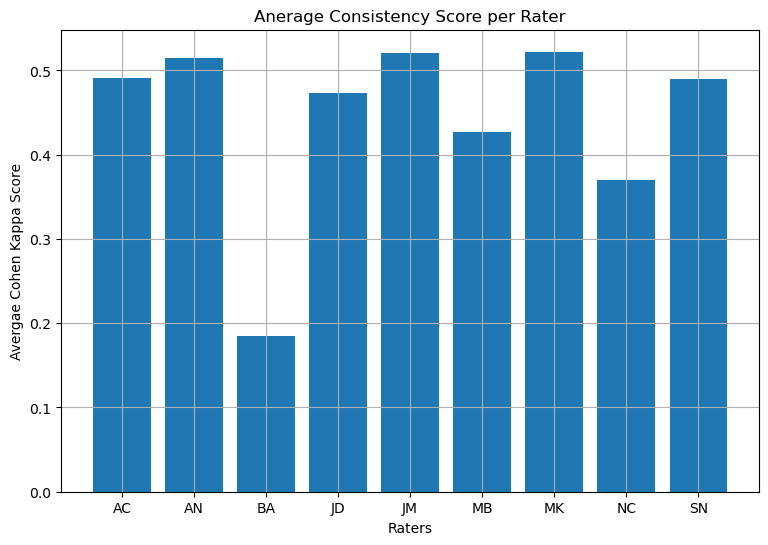

In [20]:
plt.figure(figsize=(9, 6))
plt.bar(consistency_matrix.index, (consistency_matrix.mean() - 11.0))
plt.grid(True)
plt.title(f"Anerage Consistency Score per Rater")
# plt.xticks(consistency_matrix.index, [f'Rater {i+1}' for i in range(len(consistency_matrix.index))])
# plt.xticks(consistency_matrix.index, [f'Rater {i+1}' for i in range(len(consistency_matrix.index))])
plt.xlabel("Raters")
plt.ylabel("Avergae Cohen Kappa Score")
# plt.savefig('Consistency Evaluation - per Rater Pair.png')
plt.show()

In [25]:
(consistency_matrix.mean() - 11.0).sort_values(ascending=False)

MK    0.522222
JM    0.521111
AN    0.514444
AC    0.491111
SN    0.490000
JD    0.473333
MB    0.426667
NC    0.370000
BA    0.184444
dtype: float64

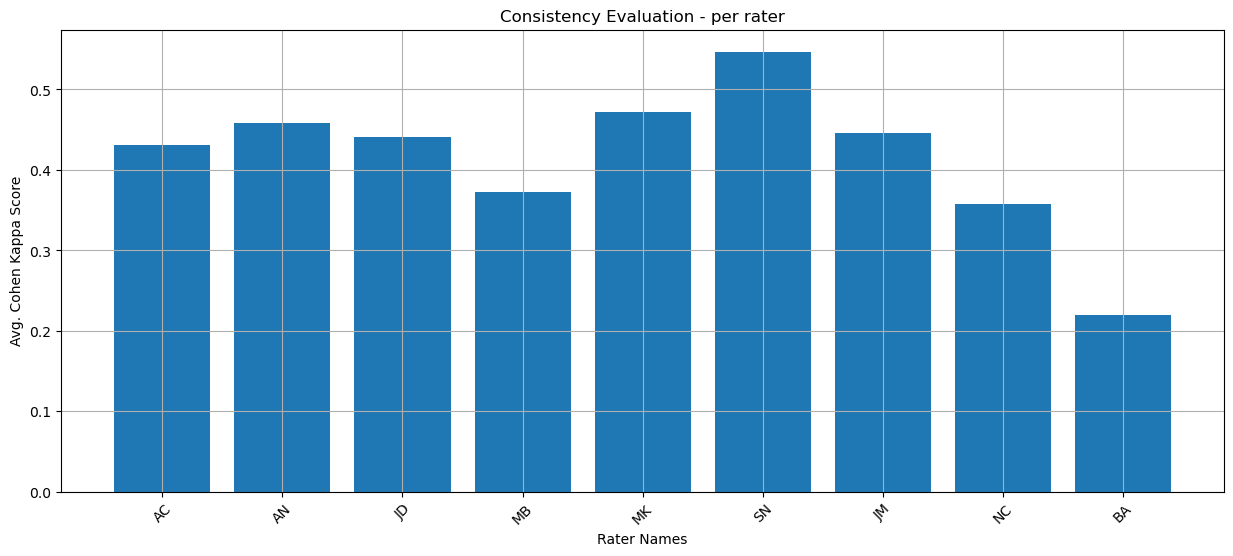

In [15]:
rater_names = list(individual_rater_score.keys())
values = list(individual_rater_score.values())
plt.figure(figsize=(15, 6))
plt.bar(range(len(individual_rater_score)), [np.average(individual_rater_score[rater]) for rater in individual_rater_score.keys()], tick_label=rater_names)
plt.xticks(rotation=45)
plt.grid(True)
plt.title("Consistency Evaluation - per rater")
plt.xlabel("Rater Names")
plt.ylabel("Avg. Cohen Kappa Score")

plt.savefig('Consistency Evaluation per Rater.png')
plt.show()

# for rater in individual_rater_score.keys():
#     print(f'{rater} : {np.round(np.average(individual_rater_score[rater]), 2)}  {len(individual_rater_score[rater])}')

In [16]:
np.average(all_pairwise_scores)

0.43418604651162795

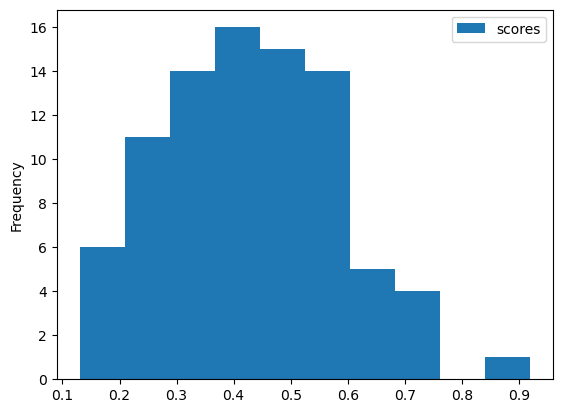

In [17]:
ax = all_pairwise_scores.plot.hist() # bins=12, alpha=0.5

<Axes: ylabel='Density'>

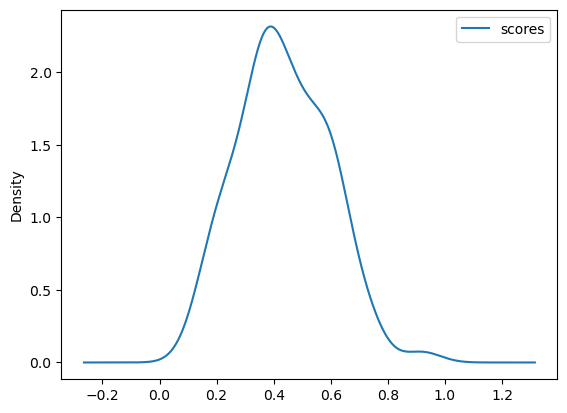

In [18]:
all_pairwise_scores.plot.kde()

In [19]:
new_data = dict()

for file_id in id_locations.keys():
    total_words = []
    all_words = []
    rater_names = []
    for file_location in id_locations[file_id]:
        rater = file_location.split('/')[2].split()[1]
        if rater not in ['BA']: # 'MB', 'NC', 
            doc = Document(file_location)
            total_string = []
            prev, curr = 'normal_text', 'normal_text'
            for paragraph in doc.paragraphs:
                runs = paragraph.runs
                n_runs = len(runs)
                temp_string = ""
                for i in range(n_runs):
                    if runs[i].font.highlight_color:
                        if runs[i].font.highlight_color == color_2_num['YELLOW']:
                            curr = color_2_label['YELLOW']
                        elif runs[i].font.highlight_color == color_2_num['BRIGHT_GREEN']:
                            curr = color_2_label['BRIGHT_GREEN']
                        elif runs[i].font.highlight_color == color_2_num['DARK_YELLOW']:
                            curr = color_2_label['DARK_YELLOW']
                        elif runs[i].font.highlight_color == color_2_num['RED']:
                            curr = color_2_label['RED']
                        elif runs[i].font.highlight_color == color_2_num['TURQUOISE']:
                            curr = color_2_label['TURQUOISE']
                        elif runs[i].font.highlight_color == color_2_num['GRAY']:
                            curr = color_2_label['GRAY']
                    else:
                        curr = 'normal_text'
                        
                    if curr == prev:
                        temp_string += re.sub(alpha_num, ' ', runs[i].text)
                    else:
                        total_string += [[i, prev] for i in temp_string.strip().split() if i.strip()]
                        temp_string = re.sub(alpha_num, ' ', runs[i].text)
                        
                    if i == n_runs - 1:
                        total_string += [[i, curr] for i in temp_string.strip().split() if i.strip()]
    
                    prev = curr
            total_words.append(len(total_string))
            all_words.append(total_string)
            rater_names.append(rater)
    
    if all(i == total_words[0] for i in total_words) and len(total_words) > 1:
        new_data[file_id] = all_words

In [20]:
all_lables = [
    "Thesis",
    "Organizational Framework",
    "Rhetorical Structure - Focus",
    "Evidence",
    "Reasoning",
    "Rhetorical Structure - Progression",
    "normal_text"
    ]

In [21]:
scores_per_label = dict()
avg_per_label = dict()
for label in all_lables:
    label_score = dict()
    for file_id in new_data.keys():
        temp_data = new_data[file_id]
        n_raters = len(temp_data)
        all_scores = []
        for i in range(n_raters-1):
            for j in range(1, n_raters):
                df1 = pd.DataFrame(temp_data[i], columns =['word', 'label']).replace([i for i in all_lables if i != label], f'Not {label}')
                df2 = pd.DataFrame(temp_data[j], columns =['word', 'label']).replace([i for i in all_lables if i != label], f'Not {label}')
                labels = list(set(df1.label.unique()).union(df2.label.unique()))
                if len(set(labels)) != 1:
                    score = cohen_kappa_score(df1.label, df2.label, labels=labels)
                    all_scores.append(score)
        if len(all_scores) != 0:
            avg_score = round(sum(all_scores)/len(all_scores) * 100, 2)
            label_score[file_id] = avg_score
    scores_per_label[label] = label_score
    avg_per_label[label] = np.round(np.average([*label_score.values()]), 2)

In [22]:
avg_per_label

{'Thesis': 70.97,
 'Organizational Framework': 25.8,
 'Rhetorical Structure - Focus': 33.34,
 'Evidence': 79.8,
 'Reasoning': 54.51,
 'Rhetorical Structure - Progression': 16.32,
 'normal_text': 48.35}

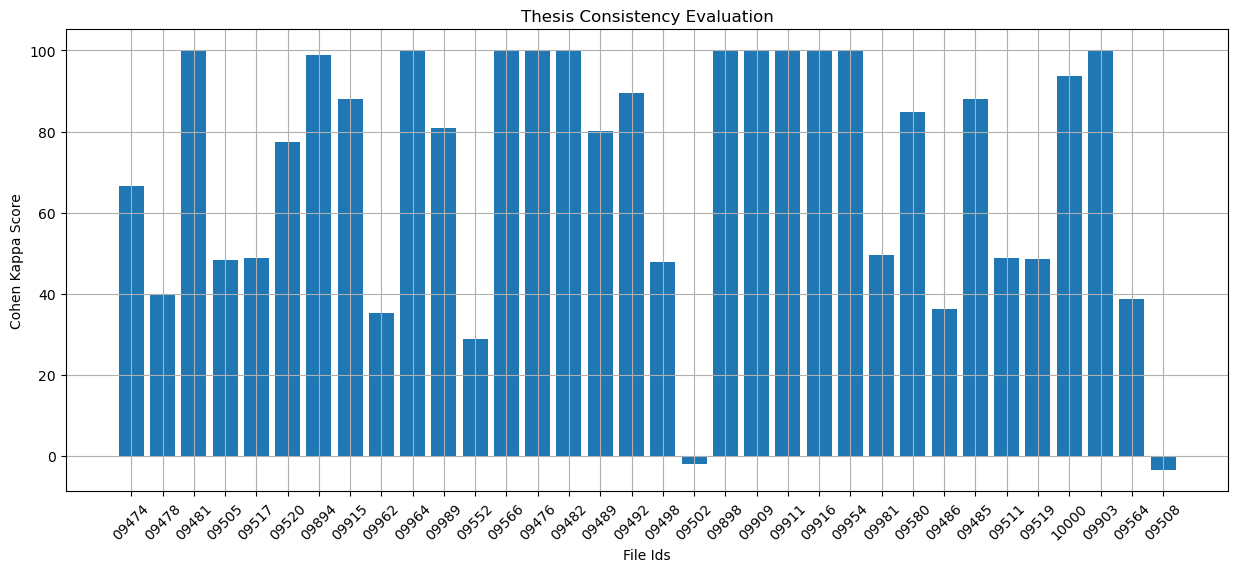

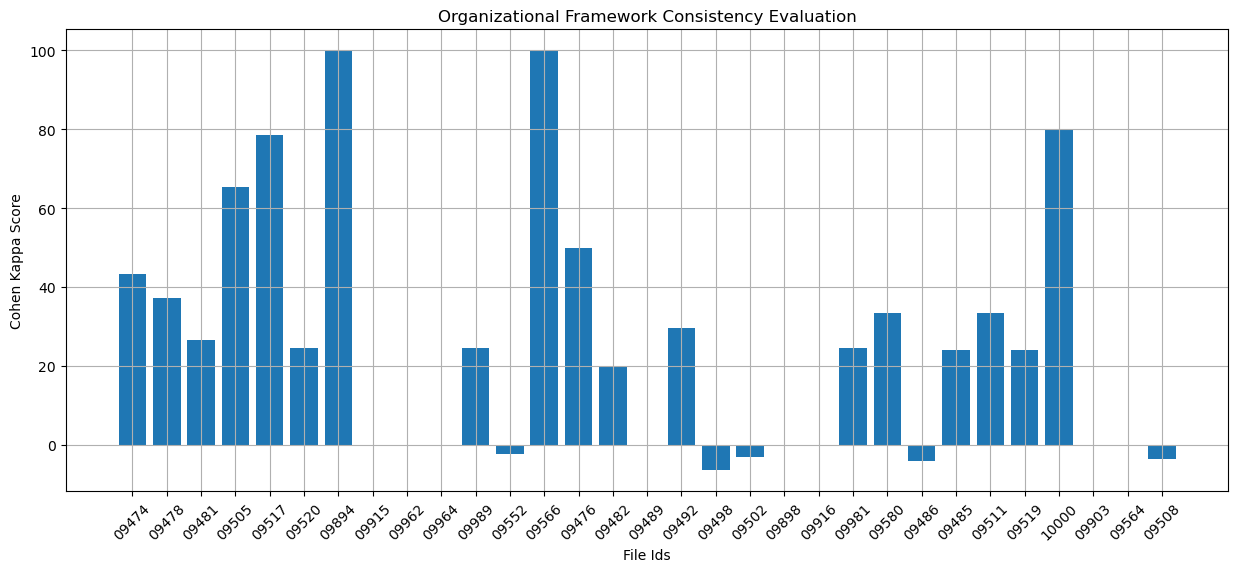

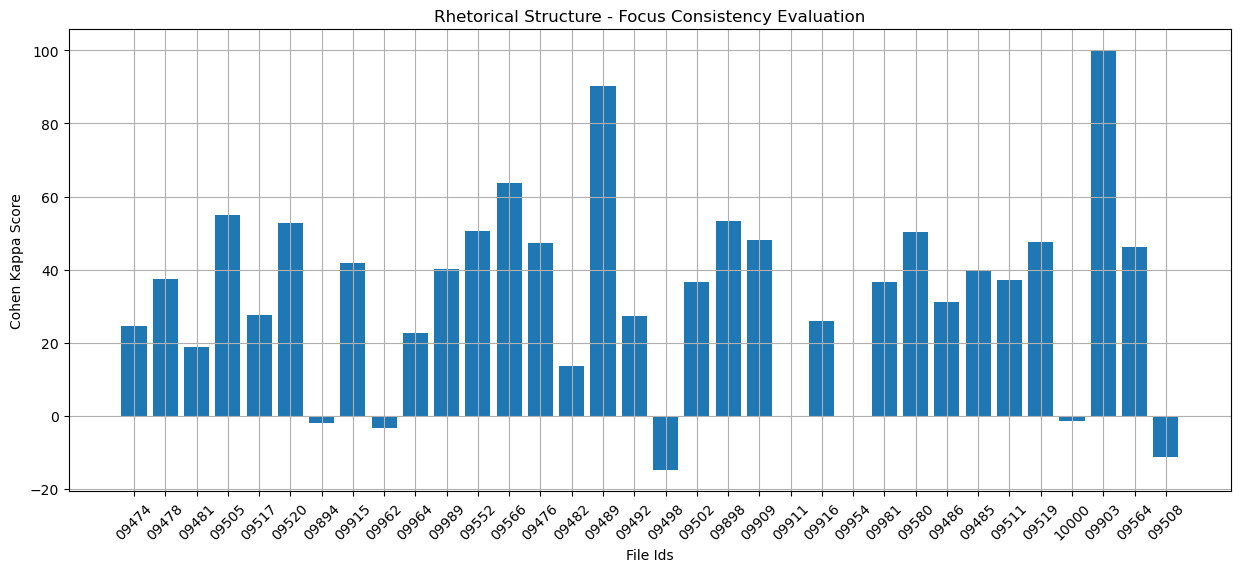

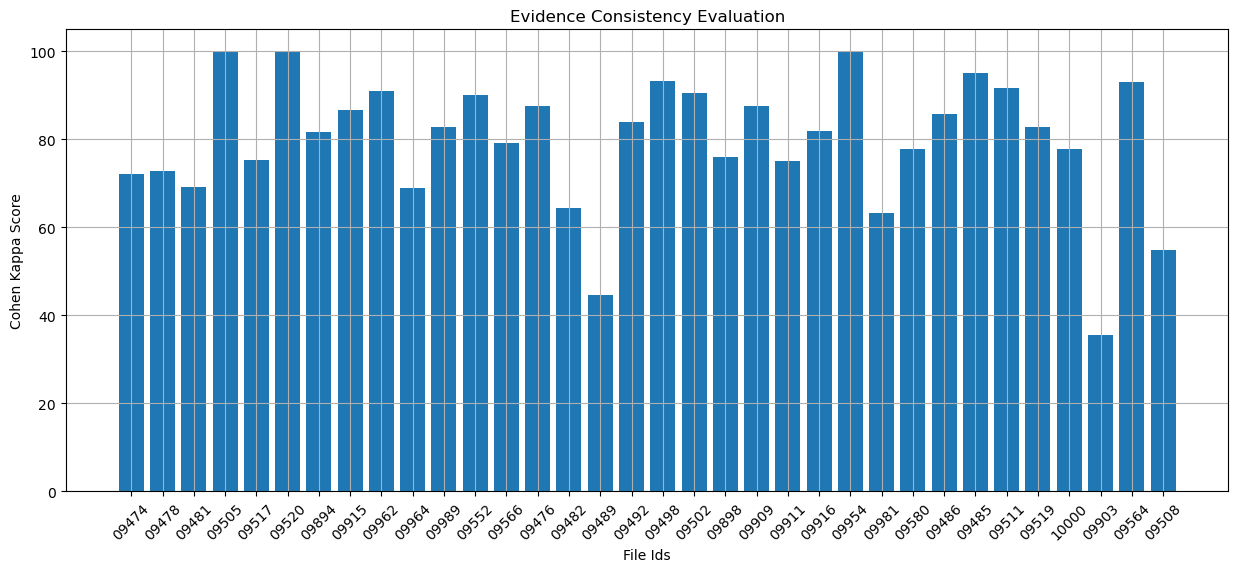

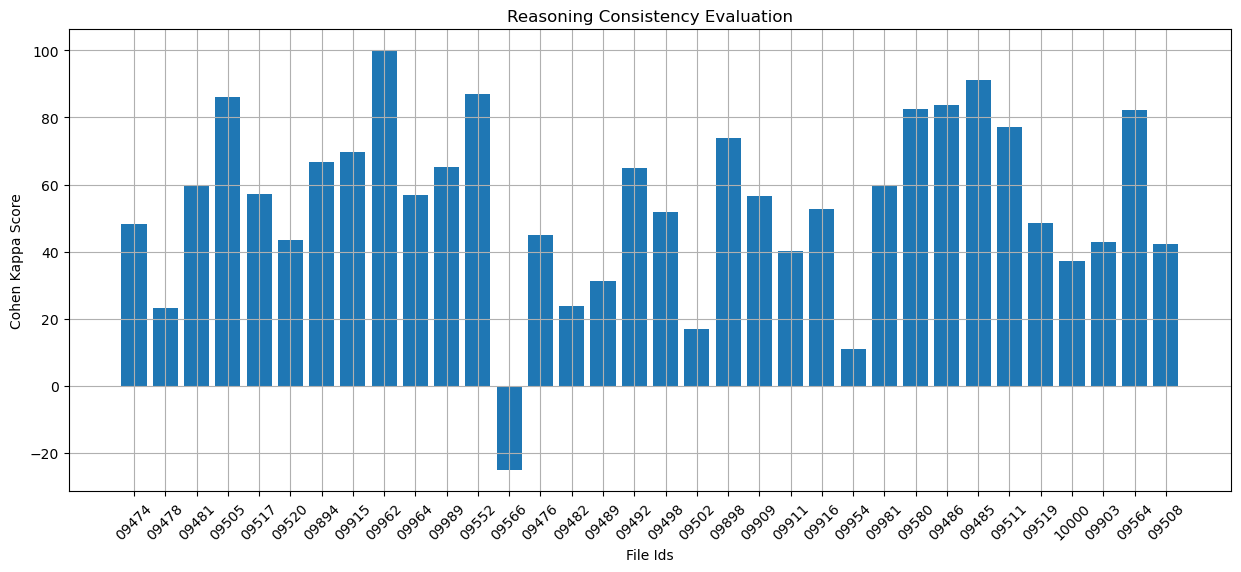

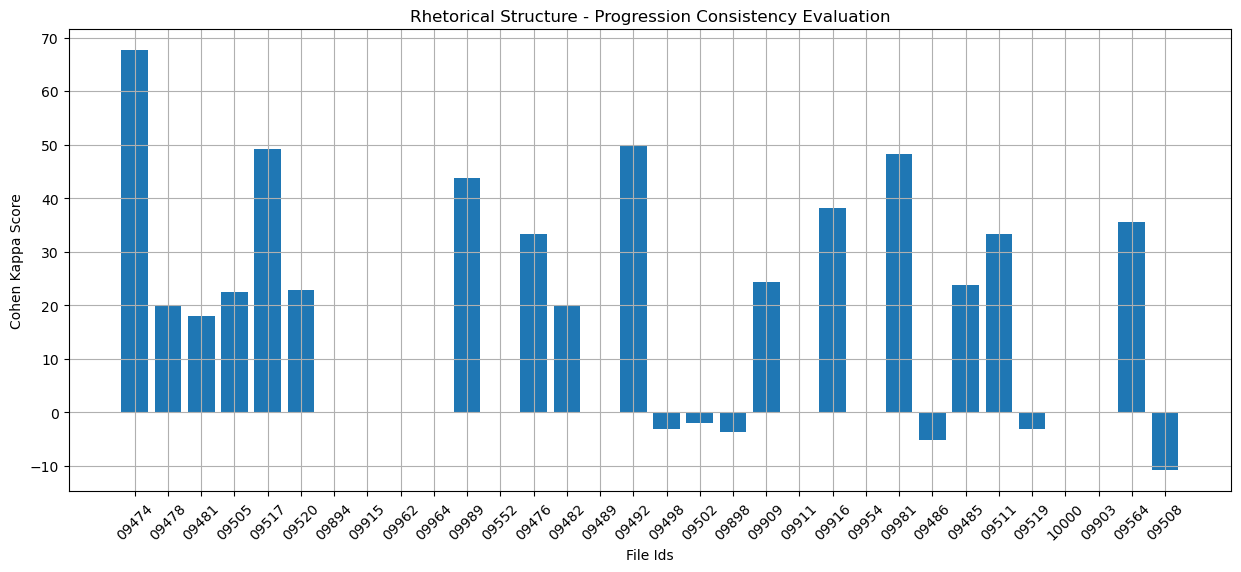

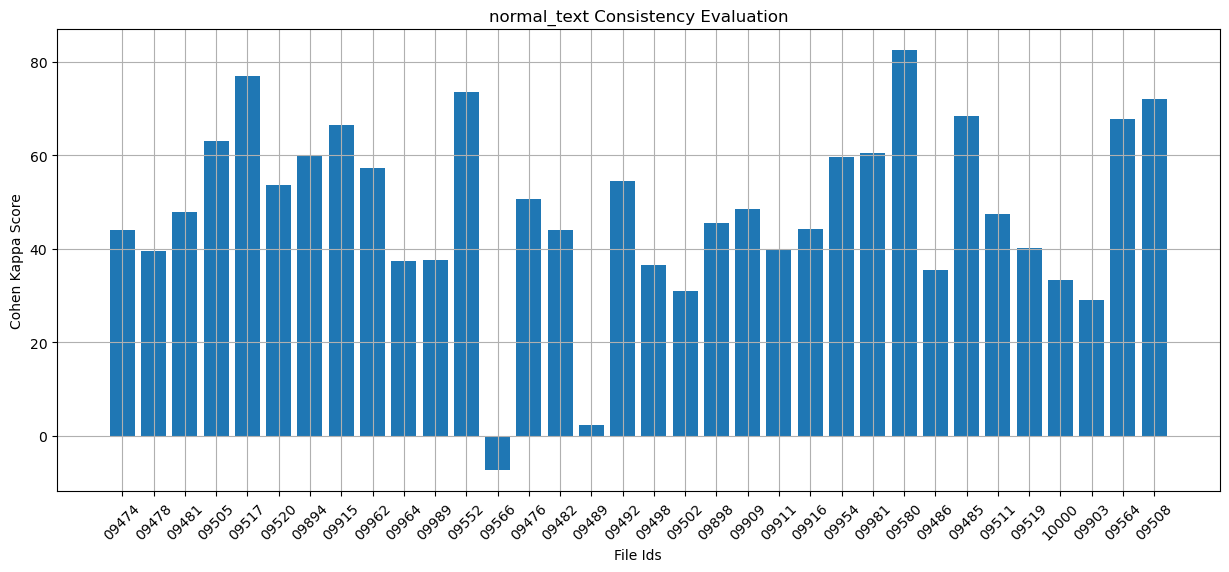

In [23]:
for label in scores_per_label.keys():
    file_ids = list(scores_per_label[label].keys())
    values = list(scores_per_label[label].values())
    plt.figure(figsize=(15, 6))
    plt.bar(range(len(scores_per_label[label])), values, tick_label=file_ids)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.title(f"{label} Consistency Evaluation")
    plt.xlabel("File Ids")
    plt.ylabel("Cohen Kappa Score")
    
    plt.savefig(f'Consistency Evaluation - {label}.png')
    plt.show()

In [24]:
kappa_scores = dict()
for file_id in new_data.keys():
    temp_data = new_data[file_id]
    n_raters = len(temp_data)
    all_scores = []
    for i in range(n_raters-1):
        for j in range(1, n_raters):
            df1 = pd.DataFrame(temp_data[i], columns =['word', 'label'])
            df2 = pd.DataFrame(temp_data[j], columns =['word', 'label'])
            labels = list(set(df1.label.unique()).union(df2.label.unique()))
            if len(set(labels)) != 1:
                score = cohen_kappa_score(df1.label, df2.label, labels=labels)
                all_scores.append(score)
    if len(all_scores) != 0:
        avg_score = round(sum(all_scores)/len(all_scores) * 100, 2)
        kappa_scores[file_id] = avg_score

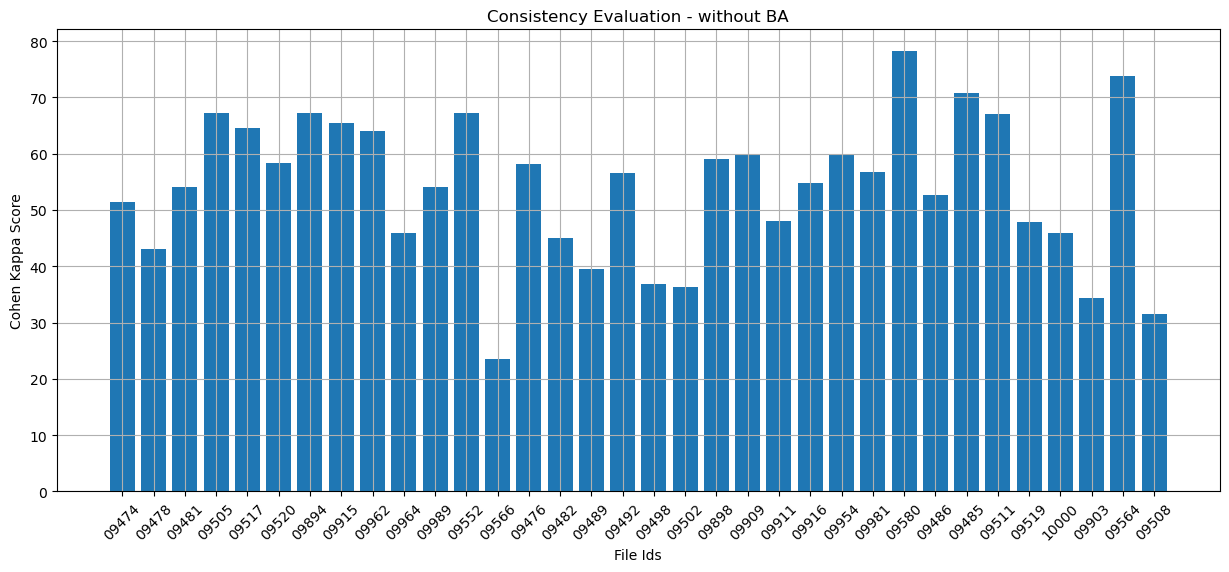

In [25]:
file_ids = list(kappa_scores.keys())
values = list(kappa_scores.values())
plt.figure(figsize=(15, 6))
plt.bar(range(len(kappa_scores)), values, tick_label=file_ids)
plt.xticks(rotation=45)
plt.grid(True)
plt.title("Consistency Evaluation - without BA")
plt.xlabel("File Ids")
plt.ylabel("Cohen Kappa Score")

plt.savefig('Consistency Evaluation - without BA.png')
plt.show()

In [26]:
# np.average([*kappa_scores.values()])

In [27]:
# a1, a2 = two
# n1, n2 = len(a1), len(a2)

# print(n1, n2)

# if n1 > n2:
#     a2 += ["POOP!" for i in range(n1 - n2)]
# else:
#     a1 += ["POOP!" for i in range(n2 - n1)]

# for i, j in zip(a1, a2):
#     print(i, j)